In [22]:
import csv
import time
import pandas as pd
import numpy as np
import re
import string
# for using counter
import collections
# for visualisations
import matplotlib
import matplotlib.pyplot as plt
# from __future__ import print_function
# import sys
# print(sys.executable)

## Libraries required

* csv
* time
* pandas
* numpy 
* re
* string
* collections
* tweepy
* os
* sys
* bs4
* urllib
* textblob
* nltk
* oauth2
* base64
* requests
* json
* matplotlib
* matplotlib.pyplot
* mpl_toolkits.basemap
* wordcloud 



## High Level Overview

#### Product Overview

Client (anonymous) wishes to understand the consumer sentiment over twitter on the recent “Cambridge Analytics” event.

#### Product Features

* Feature1: Tweets
* Feature2: Twitter Users Locations (Google Geocode)
* Feature3: Twitter User Information
* Feature4: Sentiment Analysis
* Feature5: Geo-spatial Analysis

## Introduction

The following is a Project on 'how an individual can leverage data available over social media such as Twitter'. 
The types of analysis that we could perform such as:
* Select a Subject or topic of discussion (for us this is **Cambridge Analytics issue faced by Facebook**) 
* Mood classification or Sentimenet analysis 
* geospatial analysis and other forms of intuitive visualisations

For ultimately being able to better communicating results to stakeholders. This is a growing feild of study and research by policy, psychology and science students.

There are several parts to this tutorial but largely we could divide them into three parts:
* Access Twitter API
    * Authentication (oauth2)
    * Pagination
    * Rate Limiting
* Simple Sentiment Analysis (using TextBlob or our own classifier)
* Geo-Spatial Analysis

You may also download the "facebook_related_tweets.csv" [from my google drive (68 mb)](https://drive.google.com/open?id=10s9Ldj_gawj_DC5UZhWCbebjPeK2KqXW). Other files such as "google_gecode_locations.csv" or "twitter_users_information.csv", will also be availabel on [git hub code repository](https://github.com/pranavbhatt291/Data-Focused-Python).


(**Note:** references used to develp code chunks would be provided above the chunk along with description)

## Authentication

Most large web scale companies use a combination of authentication and rate limiting to control access to their data to ensure that everyone using it abides by them. Twitter uses the oauth2 authentication and hence we will go forward to apply for a developer account.

## Twitter API Access

**1.** Create a Twitter Account (if you dont have one already)

**2.** Go [here](https://apps.twitter.com/app/new) and log in. 

**3.** In 'Application Management' - 'Create an Application'. Enter 'Name', 'Description' & 'Website' (can be dummy)

## Authentication

Most large web scale companies use a combination of authentication and rate limiting to control access to their data to ensure that everyone using it abides by them. Twitter uses the oauth2 authentication and hence we will go forward to apply for a developer account.

## Twitter API Access

**1.** Create a Twitter Account (if you dont have one already)

**2.** Go [here](https://apps.twitter.com/app/new) and log in. 

**3.** In 'Application Management' - 'Create an Application'. Enter 'Name', 'Description' & 'Website' (can be dummy)

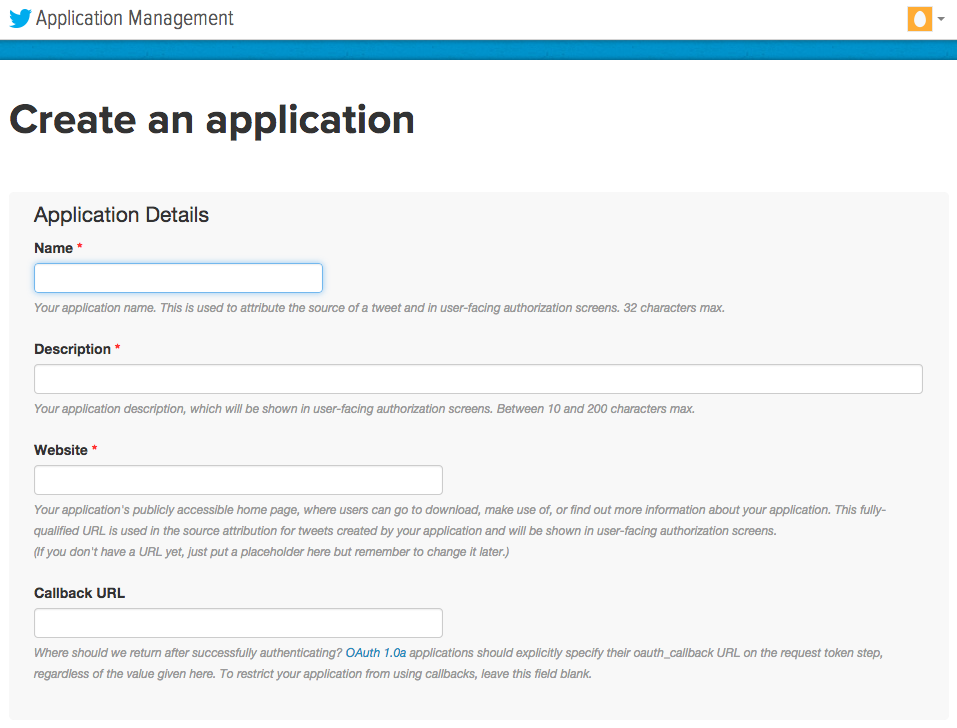

**4.** Accept the Terms of Service and click 'Create the application'

**5.** Go to 'Keys and Access Tokens'. Scroll down and select 'Create my Access Tokens' to get the Access key and Secret as well

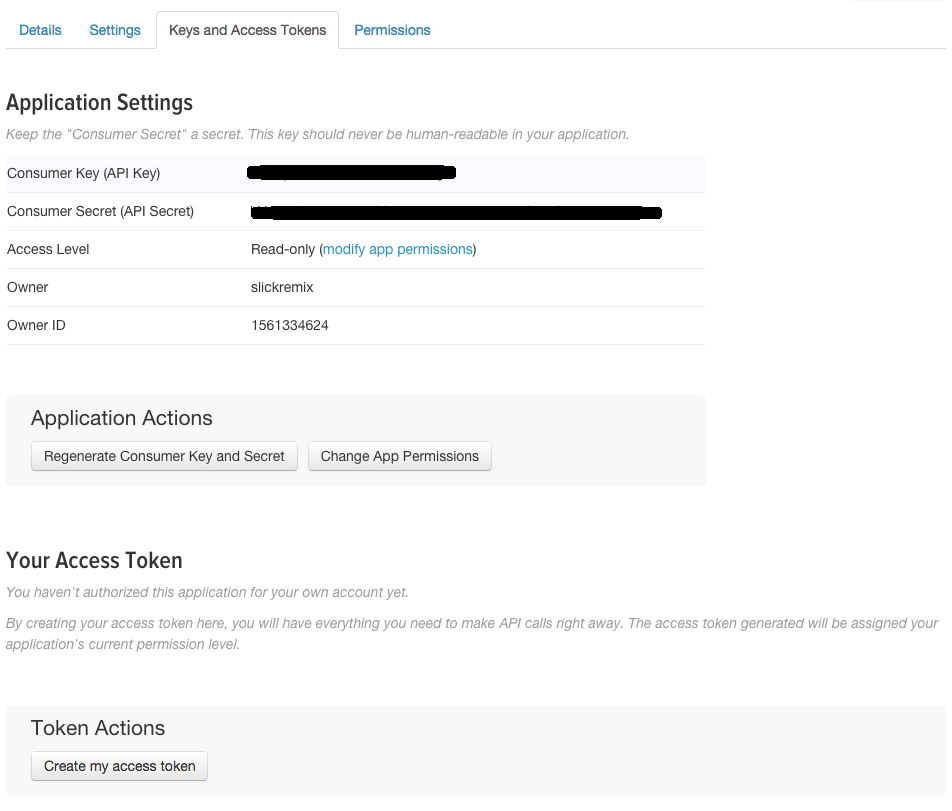

**6.** Save the keys in one file (as shown below) and access (or extract) them using the below function:

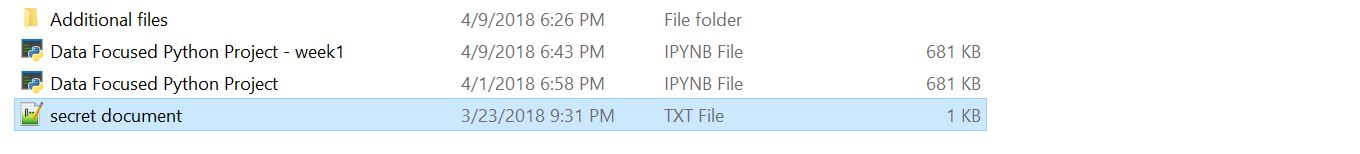

```python
>>> print(api_key, api_secret, access_token_key, access_token_secret)

api_key = "your_api_key"
api_secret = "your_api_secret"
access_token_key = "your_access_token_key"
access_token_secret = "your_access_token_secret"
```

In [3]:
def read_api_key(filepath):
    """
    Read the Twitter API Key information from file.
    Args:
        filepath (string): File containing all the API/Access Key & Secret
    Returns:
        api_key (string): The API Key
        api_secret (string): The API Secret
        access_token_key (string): The Access Token Key
        access_token_secret (string): The Access Token secret
        
    """
    with open(filepath, 'r') as f:
        store_text_file = f.read()
        api_key = re.findall(r'api_key = "(\w+)"', str(store_text_file))[0]
        api_secret = re.findall(r'api_secret = "(\w+)"', str(store_text_file))[0]
        access_token_key = re.findall(r'access_token_key = "(\w+-\w+)"', str(store_text_file))[0]
        access_token_secret = re.findall(r'access_token_secret = "(\w+)"', str(store_text_file))[0]
    return (api_key, api_secret, access_token_key, access_token_secret)     
    
api_key, api_secret, access_token_key, access_token_secret = read_api_key("secret document.txt")

## Twitter API

We will first explore 'Twitter' by simply exploring the **request** library. The procedure is as mentoined below:
* First 'API key & secret' and encode in the ASCII  format
* Use the **base64** library to encode the the key.
* Authorization in the 'headers' parameters where we pass this encoded key (along with some other parameters).
* Check for Status (200 OK) and keys that we can use from data response (access_token).
* Extract the tweets
* Our observations from 'studying the tweets'

Source:

* [References 1](https://speca.io/speca/twitter-rest-api-v1.1)
* References 2 : Influence used from a prior idea that we had in Practical Data Science course

(**Note:** This is a simple User Authentication that permits 180 requests per 15 mins and maximum 100 tweets per each)

In [4]:
import oauth2 as oauth
import base64
import requests
import json

In [5]:
key_secret = '{}:{}'.format(api_key, api_secret).encode('ascii')
b64_encoded_key = base64.b64encode(key_secret)
b64_encoded_key = b64_encoded_key.decode('ascii')

In [6]:
url = '{}oauth2/token'.format('https://api.twitter.com/')

headers = {
    'Authorization': 'Basic {}'.format(b64_encoded_key),
    'Content-Type': 'application/x-www-form-urlencoded;charset=UTF-8'
}

data = {
    'grant_type': 'client_credentials'
}

auth_resp = requests.post(url, headers=headers, data=data)
print('Status Code (check) : ',auth_resp.status_code)
print('Keys in data response : ', auth_resp.json().keys())

Status Code (check) :  200
Keys in data response :  dict_keys(['token_type', 'access_token'])


### Lets Extract tweets:

* Simply re-use the tokens access tokens as in above. Here the **json** library can be put to work.
* Create a 'Search Parameter' with the following keys:
    * 'search query' as 'facebook'
    * 'language' as 'en' (ISO format)
    * 'result' as 'popular' (can be 'mixed' or 'recent' as well)
    * 'count of tweets' as 5 (to sample, maximum can be 100)

In [7]:
access_token = auth_resp.json()['access_token']
search_headers = {
    'Authorization': 'Bearer {}'.format(access_token)    
}

search_params = {
    'q': 'facebook',
    'lang': 'en',
    'result_type': 'popular',
    'count': 5
}

url = '{}1.1/search/tweets.json'.format('https://api.twitter.com/')

search_resp = requests.get(url, headers=search_headers, params=search_params)
tweet_data = search_resp.json()
for x in tweet_data['statuses']:
    print(x['text'])
    print(" ------------------------------ ")

Surrounded by police on all sides, tracked by a helicopter, a group of young Black women come face the face w/ deat… https://t.co/KyAMGv0zLV
 ------------------------------ 
Tory chair @BrandonLewis defended decision to reinstate racist Pendle councillor. Apparently she meant to delete th… https://t.co/xE8rjwk9qe
 ------------------------------ 
Black women move bags to car as they leave an AirBnB. Cops lock down neighborhood, bring in helicopter. White neigh… https://t.co/bK9jpnkFvj
 ------------------------------ 
Did Mark Zuckerberg lie to Congress? Damning new evidence show models derived from Facebook data not deleted as Zuc… https://t.co/62XHTxg68f
 ------------------------------ 
WhatsApp co-founder Jan Koum is leaving Facebook after clashing over data privacy https://t.co/iQ0y6ksGji https://t.co/8oHRWoHAZ5
 ------------------------------ 


### Observation from exploring above tweets

We can observe the following:
* Several tweets are not being able to process and are getting cut-out from the text, this is because of the charachter limit.
* Once we save this text on-to a csv like file several white spaces (tabs, newlines, etc.) will ruin the formatting of our table
* There is alot of unecessary text like emoticons, links, hastags, slangs etc. in our tweets text that we do not require
* We have displayed 5 popular tweets related to the search  There are a few caveats to pagination, rate limiting and ultimately authentication (user & application) that make a difference to the way we approach the problem

## Access Twitter using 'Tweepy' 

As we have discussed above 'user authentication' has its own limitations. "Tweepy" is a well known twitter library that has been developed which will increase the request to 450 per 15 minuites. It gives fexibillity to user to better manage **pagination** & **rate limiting** (wait_on_rate_limit & wait_on_rate_limit_notify). It returns a simple json, that can be easily parsed and information can be extracted.

We would like to attempt to access twitter using 'tweepy' and extract a small sample of 5 tweets to analyse its working. Also, get the 'full text' of the tweet and not use incomplete tweets going forward.

(**Note:** For more information on Tweepy, please click on the [link](http://docs.tweepy.org/en/v3.5.0/).



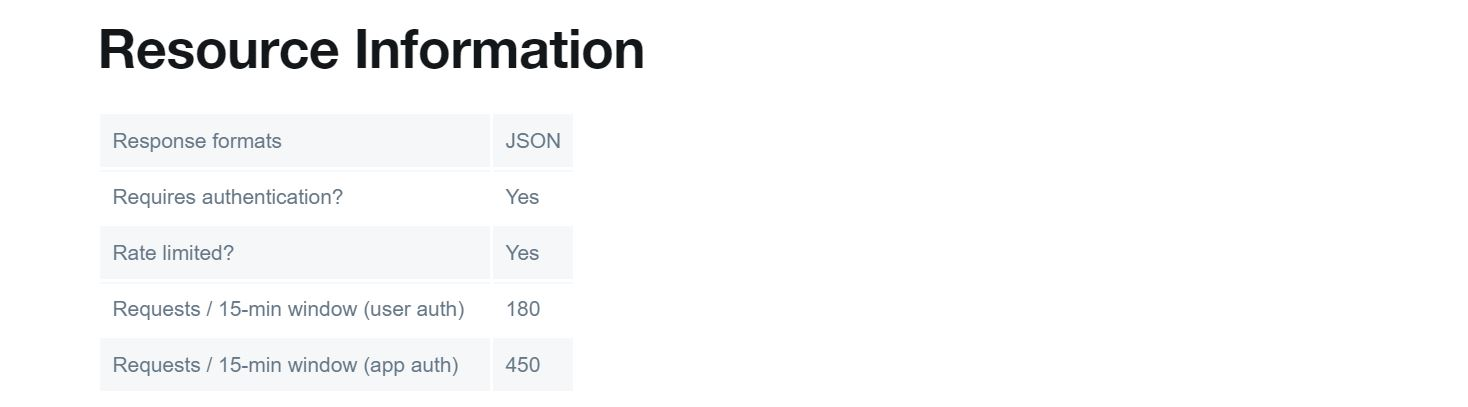

Source:

[Reference 1](https://developer.twitter.com/en/docs/tweets/search/api-reference/get-search-tweets)

In [8]:
import tweepy
from tweepy.streaming import StreamListener
from tweepy import Stream
from tweepy import OAuthHandler

In [9]:
auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token_key, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [10]:
fetched_tweets = api.search(q = 'facebook', lang='en', tweet_mode="extended", show_user=True, count = 5)
for one_tweet in fetched_tweets:
    print(one_tweet.full_text)
    print(" ----------------- ")

Retweeted #RealTalkWithAnele 6pm SABC3 (@RealTalkOn3):

After being rejected 3years @AudioTheBrand - Fezile Dhlamini then decided to push his own start-up, Green Scooter. Tonight he joins us on... https://t.co/3WrEsSRRQR
 ----------------- 
RT @KerryThomas20: I’ve been emailing the link to my friends and family who are not on twitter &amp; Facebook asking them to sign. I encourage…
 ----------------- 
RT @blroperchick: Hey Twitter, I’m starting my own business making custom rodeo shirts! I will be making them and posting them for sale and…
 ----------------- 
RT @INorBY2020: Live Stream on Facebook from 1950s Battlebus 8 May 2018 12.15 with Michael Mansfield QC. @BBCnews @ITVnews @channel4 @Skyne…
 ----------------- 
RT @ArtyLMSN: Top10 Facebook Growth Rate @ 7 May 18
1 #PunBNK48 +2391
2 #CherprangBNK48 +1502
3 #NoeyBNK48 +1421
4 #OrnBNK48 +1299
5 #Music…
 ----------------- 


### Observation from exploring tweets

We can observe the following:
* Manage 'retweeted tweets', as they are incomplete even after using (tweet_mode='extended') which was supposed to get the complete tweet text but did not :(.
* We still need to clean the text to read the feilds in our csvfile (tabs, newlines, etc.), which might ruin the formatting of our table and prevent us from performing our tasks.
* There is still alot of noise in our text like links, emoticons, hastags, punctuations etc.

Lets create the following:
* Cleaning tweets function: that will deal with our point 2 and 3 above.
* Code that maintain retweets as well and saves other feilds to a csv file. 

In [12]:
def clean_my_tweets(text_tweet):
    # convert into lower space
    check_text = text_tweet.lower()
    # strip /n from the lines in the text
    check_text = check_text.strip()
    # replace - with spaces
    new_str = check_text.replace("-", " ")
    # replace 's with null
    new_str = new_str.replace("'s", "")
    # replace ' with blank
    new_str = new_str.replace("'", "")
    # replace " with blank
    new_str = new_str.replace('"', "")
    # replace . with blank (beacuse countries are sometimes abbreviated using the same)
    new_str = new_str.replace('.', "")
    # remove mentions such as @realdonaltrump, managing mentions
    new_str = re.sub(r"@[\w]+", " ", new_str)
    # remove hashtags such as #deletefacebook
    new_str = re.sub(r"#[\w]+", " ", new_str)
    # remove urls such as https://t.co/nxIgrc3hdi
    new_str = re.sub(r"http\S+", " ", new_str)
    # replace any punctuation using import string.punctuation also removes special charachters
    for c in string.punctuation:
        new_str = new_str.replace(c, " ")
    # replace all types of white spaces : matches any whitespace character \r \n \t \f \v
    text_content = re.sub(r"\s+", " ", new_str)
    return text_content

Run the below test cases for tweets (cleaning them)

In [13]:
# print(clean_my_tweets("*On, Facebook* --- ' ~!@#$%^&*`_+=;|  oianc's \n \n Girl : Tell me something that I don't know."))
# print(clean_my_tweets("https://t.co/nxIgrc3hdi oianc's \n \n @realdonaltrump : Tell me something that I don't know. "))
# print(clean_my_tweets("#deletefacebook Tell me I'm confused, What to do ... ???  https://t.co/nxIgrc3hdi "))
# print(clean_my_tweets("""zuckerberg so we censor conservatives, regulate me ... https://t.co/ois0endefq right 
#             facebook = dashboard for cia/nsa, cambridge analytics junk, but good  left hrc &amp; bho. #qanon right, fb value 
#             heads down, down @realdonaldtrump https://t.co/lsk6klryll"""))
print(clean_my_tweets("""mark zuckerberg new the power of facebook. we know immigrants/cannot legally participate in the  
             election process, (ask foxnews about mexican immigrants) zuck offered the  whole emotion changing ad  
             campaign machine to the russian/u.k./mercers analytics. peanut money for a coup https://t.co/0nbbnswsry"""))

mark zuckerberg new the power of facebook we know immigrants cannot legally participate in the election process ask foxnews about mexican immigrants zuck offered the whole emotion changing ad campaign machine to the russian uk mercers analytics peanut money for a coup 


## Tweepy 'Cursor' versus 'Search'

Tweepy has three functionalities to extract data:
* Cursor
* Search
* Stream Listner

We will demonstrate 2 and not include stream listner as it will be a repetition of first two and the usage does not change.
The difference exists in the use cases, how each may be useful solution to adop as per a particular problem statement.

### Tweepy 'Cursor'

The cursor is a recently implemented functionality and is supposed to bring an improvement over the search function in terms of "rate limiting" & "pagination" which it manages by itself.

Search for **#deletefacebook**, **facebook**, **Mark Zuckerberg**, **Cambridge Analytica** and accordingly read other details.

Apply the **retweeted check** and accordingly display the full text

Apply **cleaning** before displaying the tweet

In [14]:
search_terms = '#deletefacebook OR facebook OR Mark Zuckerberg OR Cambridge Analytica'
counter = 0
# save in a csv file
with open('facebook_related_tweets_cursor.csv', 'w', newline='', encoding='utf-8') as csvFacebook:
    writer_facebook = csv.writer(csvFacebook, delimiter=',')
    writer_facebook.writerow(['row_id', 'screen_name', 'tweet_text', 'coordinates'])
    # use the Search API (api.search) in cursor
    for tweet in tweepy.Cursor(api.search, q=search_terms, lang="en", tweet_mode="extended").items(5) : # return 5 tweets        
        counter = counter + 1
        # check for retweets
        if tweet.full_text[0:4] == 'RT @' and hasattr(tweet, 'retweeted_status'):
            cleaned_tweet = clean_my_tweets(tweet.retweeted_status.full_text)
            print(cleaned_tweet)
            writer_facebook.writerow([counter, tweet.author.screen_name, cleaned_tweet, tweet.coordinates])
        else:
            cleaned_tweet = clean_my_tweets(tweet.full_text)
            print(cleaned_tweet)
            writer_facebook.writerow([counter, tweet.author.screen_name, cleaned_tweet, tweet.coordinates])
        print(" ------------------ ")
    #Display how many tweets we have collected
    print("Downloaded {} tweets".format(counter))

when it came to harvesting data cambridge analytica was an amateur operation compared to what academics have been up to for years 
 ------------------ 
america you need to watch this testimony from live in uk parliament now did cambridge analytica use psychological insights derived from facebook data in the trump campaign yes 
 ------------------ 
cambridge analytica foldswhy now today revealed two crucial ‘indisputable’ facts it’s absolutely linked to aiq amp brexit and trump campaign had access to psych profiles derived from facebook data 
 ------------------ 
cambridge analytica kept facebook data models through us election 
 ------------------ 
massachusetts ag maura healy is launching an investigation into cambridge analytica 
 ------------------ 
Downloaded 5 tweets


## Start using Twitter to store in CSV

### Tweepy 'Search'

Although, **cursor** is a newer functionality and needs much lesser code. I will still go ahead and use the **search** functionality. 

We can see from observing the csv file in which we save the feilds that the coordinates are very hard to find and require additional checks before they can be stored in a csv file. 

Additionally we will also record and use the below parts in the code:
* Define a limit, 'maximum number of tweets' that we wish to download
* Keep the 'number of tweets returned per query' constant (i.e. 100)
* Use **max_id** & **since_id** to keep a record of donwnloaded tweets and avoid any duplication
* Keep a delay timer, so as to avoid rate limit
* store the query in the csv file with the additional checks of **retweet_status** & **coordinates** 

                                   "tweet -- coordinates -- coordinates"

**Our Objective : **
* Search for 1 Million Tweets (as max number of rows of a csv file is 1,048,576)

Hence we will run our file and wait for the total number of tweets to reach a limit or extract all the tweets related to the topics defined.

Source: 
* [Reference 1](https://www.karambelkar.info/2015/01/how-to-use-twitters-search-rest-api-most-effectively./)
* [Reference 2](http://www.dealingdata.net/2016/07/23/PoGo-Series-Tweepy/)

**Note on Since_ID:** If results from a specific ID onwards are reqd, set since_id to that ID. Else default to no lower limit, go as far back as API allows.

**Note on Max_ID:** If results only below a specific ID are, set max_id to that ID. Else default to no upper limit, start from the most recent tweet matching the search query.

In [15]:
search_terms = 'facebook OR Mark Zuckerberg OR #deletefacebook OR Cambridge Analytica'

maxTweets = 1000 
tweetsPerQry = 100  

sinceId = None
max_id = -1
tweetCount = 0
counter = 0
query_per_sec = 15*60/180.0  #180 per 15 minutes just to be safe as we know that we have 450 per 15 minuites

# store in a csv file
with open('facebook_related_tweets_search.csv', 'w', newline='', encoding='utf-8') as csvFacebook:
    writer_facebook = csv.writer(csvFacebook, delimiter=',')
    writer_facebook.writerow(['row_id', 'screen_name', 'tweet_text', 'location',
                              'lat_coord', 'lon_coord'])
    # also include location information
    while tweetCount < maxTweets:
        last_update = 0
        try:
            if (max_id <= 0):
                if (not sinceId):
                    new_tweets = api.search(q=search_terms, count=tweetsPerQry, lang="en", tweet_mode="extended", 
                                            result_type='mixed')
                else:
                    new_tweets = api.search(q=search_terms, count=tweetsPerQry, lang="en", tweet_mode="extended", 
                                            result_type='mixed', since_id=sinceId)
            else:
                if (not sinceId):
                    new_tweets = api.search(q=search_terms, count=tweetsPerQry, lang="en", tweet_mode="extended", 
                                            result_type='mixed', max_id=str(max_id - 1))
                else:
                    new_tweets = api.search(q=search_terms, count=tweetsPerQry, lang="en", tweet_mode="extended", 
                                            result_type='mixed', max_id=str(max_id - 1), since_id=sinceId)
            # sleep / delay to avoid rate limit
            time.sleep(query_per_sec) 
            if not new_tweets:
                print("No tweets left to search for !")
                break
            # save in csv file
            for tweet in new_tweets:
                counter = counter + 1
                # condition to manage missing coordinates
                if tweet.coordinates is not None:
                    pri_XY_coord = [tweet.coordinates['coordinates'][0], tweet.coordinates['coordinates'][1]]
                else:
                    pri_XY_coord = ['','']
                # condition to manage retweets
                if tweet.full_text[0:4] == 'RT @' and hasattr(tweet, 'retweeted_status'):
                    cleaned_tweet = clean_my_tweets(tweet.retweeted_status.full_text)
                    writer_facebook.writerow([counter, tweet.author.screen_name, cleaned_tweet, tweet.user.location,
                                              pri_XY_coord[1], pri_XY_coord[0]])
                else:
                    cleaned_tweet = clean_my_tweets(tweet.full_text)
                    writer_facebook.writerow([counter, tweet.author.screen_name, cleaned_tweet, tweet.user.location,
                                              pri_XY_coord[1], pri_XY_coord[0]])
            # for countdown
            tweetCount = tweetCount + len(new_tweets)
            print("Countdown {} (downloaded {})".format(maxTweets-tweetCount, tweetCount))
            max_id = new_tweets[-1].id
        # exception erro catch
        except tweepy.TweepError as e:
            # Just exit if any error
            print("Exception caught (error) : " + str(e))
            break

Countdown 900 (downloaded 100)
Countdown 800 (downloaded 200)
Countdown 700 (downloaded 300)
Countdown 600 (downloaded 400)
Countdown 500 (downloaded 500)
Countdown 400 (downloaded 600)
Countdown 300 (downloaded 700)
Countdown 200 (downloaded 800)
Countdown 100 (downloaded 900)
Countdown 0 (downloaded 1000)


# The Coordinates problem

Coordinates are extreemly hard to find for the tweets as the users have not shared or geo-tagged their tweets hence we need to take another feild that would be better in terms of obtaining the latitude and Longitude. 

In the above chunk of code we are recording the coordinates of the geo-tagged tweets, where the user tags the tweet by enabling and sharing the location. We will continue to record these coordinates but as our **secondary lat & long**. 

In the below chuck we are going to record those tweets where the users have enabled their location, which can be seen by:

                            "tweet -- place -- bounding box -- coordinates"

This gives us a bounding box, where we will apply a calculation to get the center and save the coordinates of those as our **primary lat & long**.

* Total number of tweets found related to our search terms : **362,753**
* Total number of primary coordinates found: **1195**
* Total number of secondary coordinates found: **50**

**Time delay are extreemly useful** used as "query_per_sec" in our code. This prevents twitter from identifying us as a bot and restricting our access.

Hence, the decision to select the 'bounding box' feild was a much better one than simply using 'coordinates' feild.

(**Note:** The end file was renamed and stored as "facebook_related_tweets.csv")

In [17]:
search_terms = 'facebook OR Mark Zuckerberg OR #deletefacebook OR Cambridge Analytica'

# uncomment below line if you wish to run this file and leave it overnight to extract tweets.
# maxTweets = 1000000 # 1 Million tweets
# comment below line if you wish to run this file and leave it overnight to extract tweets.
maxTweets = 1000 # 1 Million tweets
tweetsPerQry = 100  
sinceId = None
max_id = -1
tweetCount = 0
counter = 0
query_per_sec = 15*60/180.0  #180 per 15 minutes just to be safe as we know that we have 450 per 15 minuites

# save data in csv file
with open('facebook_related_tweets_final.csv', 'w', newline='', encoding='utf-8') as csvFacebook:
    writer_facebook = csv.writer(csvFacebook, delimiter=',')
    writer_facebook.writerow(['row_id', 'screen_name', 'tweet_text', 'location',
                              'lat_coord', 'lon_coord', 'lat_box_coord', 'lon_box_coord'])
    # added primary and secondary coordinates along with location of the user
    while tweetCount < maxTweets:
        last_update = 0
        try:
            if (max_id <= 0):
                if (not sinceId):
                    new_tweets = api.search(q=search_terms, count=tweetsPerQry, lang="en", tweet_mode="extended", 
                                            result_type='mixed')
                else:
                    new_tweets = api.search(q=search_terms, count=tweetsPerQry, lang="en", tweet_mode="extended", 
                                            result_type='mixed', since_id=sinceId)
            else:
                if (not sinceId):
                    new_tweets = api.search(q=search_terms, count=tweetsPerQry, lang="en", tweet_mode="extended", 
                                            result_type='mixed', max_id=str(max_id - 1))
                else:
                    new_tweets = api.search(q=search_terms, count=tweetsPerQry, lang="en", tweet_mode="extended", 
                                            result_type='mixed', max_id=str(max_id - 1), since_id=sinceId)
            # sleep / delay to avoid rate limiting
            time.sleep(query_per_sec) 
            if not new_tweets:
                print("No tweets left to search for !")
                break
            # save in csv file
            for tweet in new_tweets:
                counter = counter + 1
                # condition to manage missing primary coordinates
                if tweet.place is not None:
                    bound_box_tweet = tweet.place.bounding_box.coordinates[0]                                    
                    pri_XY_coord = [(bound_box_tweet[0][0] + bound_box_tweet[2][0])/2, 
                          (bound_box_tweet[0][1] + bound_box_tweet[2][1])/2]
                else:
                    pri_XY_coord = ["",""]
                # condition to manage missing secondary coordinates
                if tweet.coordinates is not None:
                    sec_XY_coord = [tweet.coordinates['coordinates'][0], tweet.coordinates['coordinates'][1]]
                else:
                    sec_XY_coord = ['','']
                # condition to manage retweets
                if tweet.full_text[0:4] == 'RT @' and hasattr(tweet, 'retweeted_status'):
                    cleaned_tweet = clean_my_tweets(tweet.retweeted_status.full_text)
                    writer_facebook.writerow([counter, tweet.author.screen_name, cleaned_tweet, tweet.user.location,
                                              sec_XY_coord[1], sec_XY_coord[0], pri_XY_coord[1], pri_XY_coord[0]])
                else:
                    cleaned_tweet = clean_my_tweets(tweet.full_text)
                    writer_facebook.writerow([counter, tweet.author.screen_name, cleaned_tweet, tweet.user.location,
                                              sec_XY_coord[1], sec_XY_coord[0], pri_XY_coord[1], pri_XY_coord[0]])
            # countdown the downloaded tweets
            tweetCount = tweetCount + len(new_tweets)
            print("Countdown {} (downloaded {})".format(maxTweets-tweetCount, tweetCount))
            max_id = new_tweets[-1].id
        # error exception catching
        except tweepy.TweepError as e:
            # Just exit if any error
            print("Exception caught (error) : " + str(e))
            break

Countdown 900 (downloaded 100)
Countdown 800 (downloaded 200)
Countdown 700 (downloaded 300)
Countdown 600 (downloaded 400)
Countdown 500 (downloaded 500)
Countdown 400 (downloaded 600)
Countdown 300 (downloaded 700)
Countdown 200 (downloaded 800)
Countdown 100 (downloaded 900)
Countdown 0 (downloaded 1000)


### Some visual before we dive deep into the code again

We will analyse the tweeets text using a simple word cloud. This will give a visual to the audience about the contents of the tweets related to our search terms. 

Of course, there is some bias and we can see some serch terms within the word cloud but this would not reduce the value of the visual itself.

For this you would require the **wordcloud library** and read the contents of the above dataframe that we have created from "facebook_related_tweets.csv". Personally we had alot of trouble installing using pip so if by chance you do run into the same problems then we have attached the image below (which you will see if you get run the below chunk as well).

**We can clearly see that the users we talking about Mark Zuckerberg testifying before the even got the summons.**

Interesting to see that, this data is extracted on March 29, 2018 and he testified on April 10, 2018 (when even no announcment was made).



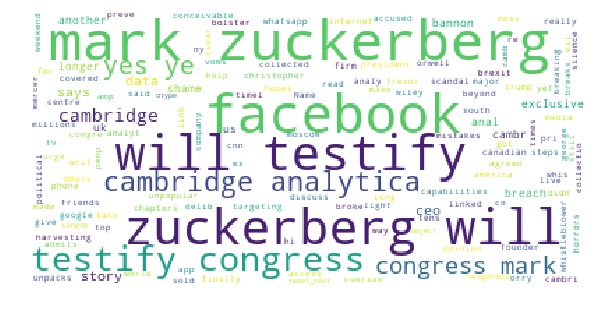

In [33]:
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS # so that we may remove the stop words

classify_tweets = pd.read_csv('facebook_related_tweets.csv', dtype={'location':object})

mpl.rcParams['figure.figsize']=(10.0,8.0)    #(6.0,4.0)
mpl.rcParams['font.size']=8                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 

wordcloud = WordCloud(background_color='white',
                      stopwords = STOPWORDS,
                      max_words=200,
                      max_font_size=40, 
                      random_state=42
                      ).generate(str(classify_tweets['tweet_text']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
# fig.savefig("word_cloud_saved.png", dpi=3000)

## Using Google Geo-code to extract more locations

To resolve the locations problem we can get the locations entered by the user and pass that to google which returns a json string that we can parse and save the location. We shall create this file and manually rename it as "google_geocode_locations.csv". This file should be joined to the original dataframe containing the tweets.

there are a few catches, such as "rate limiting" we can only process 2,500 request per day. Which means that for around 50,000 locations we would have to run for 20 days.

This is where we can distribute the wor accross multiple devices, I personally used four devices. Along with that we should realise that:

* **Out of every 180 tweets, 1 tweet has location**
* **Out of every 18 tweets, 1 tweet has location**

In [34]:
classify_tweets = pd.read_csv('facebook_related_tweets.csv', dtype={'location':object})

In [40]:
# print(classify_tweets.head(5))
locations_save = classify_tweets.loc[:, 'location'].astype(np.object)
counter = 0
locations_cleaned_list = []
# print(locations_save.head(5))
with open('google_locations.csv', 'w', newline='', encoding='utf-8') as csvFacebook:
    writer_facebook = csv.writer(csvFacebook, delimiter=',')
    writer_facebook.writerow(['row_id', 'old_location','cleaned_location'])
    for i in locations_save.unique():
        if i is not np.NaN:
            # strip /n from the lines in the text
            new_str = i.strip()
            # remove mentions such as @realdonaltrump
            new_str = re.sub(r"@[\w]+", " ", new_str)
            # remove hashtags such as #deletefacebook
            new_str = re.sub(r"#[\w]+", " ", new_str)
            # replace / with spaces
            new_str = new_str.replace("/", ", ")
            # replace | with spaces
            new_str = new_str.replace("|", ", ")
            # replace , with ", "
            new_str = new_str.replace(",", ", ")
            # split to replace whitepace with " "
            text_content = " ".join(new_str.split())
            write_location = text_content
            # increment counter
            counter = counter + 1
            writer_facebook.writerow([counter, i, write_location])

#### Cleaning the locations, as sometimes we can have poorly typed locations, which when searched for may not give a result

In [43]:
google_locations = pd.read_csv('google_locations.csv', dtype={'cleaned_location':object})
google_locations.head(5)

,row_id,old_location,cleaned_location
0,1,"Manhattan, NY","Manhattan, NY"
1,2,"Pevensey Bay, England","Pevensey Bay, England"
2,3,"Odessa, TX","Odessa, TX"
3,4,"Philadelphia, PA","Philadelphia, PA"
4,5,BRAZIL South America,BRAZIL South America


#### Using the google link we will simply return a json, that we can parse and extract the locations (latitude and longitude) to be saved within the file with respect to the cleaned locations (or the unique original locations from the tweets file)

In [ ]:
cleaned_locations_save = google_locations.loc[:, 'cleaned_location'].astype(np.object)
counter = 0
with open('google_geocode_locations_save.csv', 'w', newline='', encoding='utf-8') as csvFacebook:
    writer_facebook = csv.writer(csvFacebook, delimiter=',')
    writer_facebook.writerow(['row_id', 'cleaned_location', 'latitude', 'longitude'])
    for i in cleaned_locations_save:
        counter = counter + 1
        # if the cleaned location has some text
        if i is not np.NaN:
            new_str = i.replace(" ", "+")
            print(new_str)
            response = requests.get('https://maps.googleapis.com/maps/api/geocode/json?&address='+new_str)
            loc_json = response.json()
            time.sleep(60/300.0)
            # if there is a result returned form google response
            if  loc_json.get("results", []):
                print("... extracted")
                latitude = loc_json['results'][0]['geometry']['location']['lat']
                longitude = loc_json['results'][0]['geometry']['location']['lng']
                writer_facebook.writerow([counter, i, latitude, longitude])

#### Renaming the file to "google_geocode_locations.csv" and joining the feilds with the original file is to be performed

In [51]:
google_locations = pd.read_csv('google_gecode_locations.csv', dtype={'cleaned_location':object})
google_locations.head(5)

,row_id,old_location,cleaned_location,latitude,longitude
0,1,"Manhattan, NY","Manhattan, NY",40.7830603,-73.9712488
1,2,"Pevensey Bay, England","Pevensey Bay, England",50.8209317,0.3397311
2,3,"Odessa, TX","Odessa, TX",31.8456816,-102.3676431
3,4,"Philadelphia, PA","Philadelphia, PA",39.9525839,-75.1652215
4,5,BRAZIL South America,BRAZIL South America,-14.235004,-51.92528


In [52]:
classify_tweets = pd.read_csv('facebook_related_tweets.csv', dtype={'location':object})
classify_tweets.head(5)

,row_id,screen_name,tweet_text,location,lat_coord,lon_coord,lat_box_coord,lon_box_coord
0,1,MSNBC,exclusive yet another cambridge analytica whis...,NaN,NaN,NaN,NaN,NaN
1,2,kylegriffin1,cambridge analytica agreed to give a political...,"Manhattan, NY",NaN,NaN,NaN,NaN
2,3,RT_com,google has capabilities beyond george orwell’s...,NaN,NaN,NaN,NaN,NaN
3,4,sirrubishagrid,mark zuckerberg will testify before congress i...,NaN,NaN,NaN,NaN,NaN
4,5,KeithLockstone,how cambridge analytica’s facebook targeting m...,"Pevensey Bay, England",NaN,NaN,NaN,NaN


In [57]:
# joined_tweets = classify_tweets.join(google_locations.set_index('old_location'), on='location')
joined_tweets = classify_tweets.merge(google_locations, left_on='location', right_on='old_location', how='left')
# drop additional columns
joined_tweets.drop(['row_id_y', 'old_location','cleaned_location'], axis=1, inplace=True)
joined_tweets.head(5)

,row_id_x,screen_name,tweet_text,location,lat_coord,lon_coord,lat_box_coord,lon_box_coord,latitude,longitude
0,1,MSNBC,exclusive yet another cambridge analytica whis...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,kylegriffin1,cambridge analytica agreed to give a political...,"Manhattan, NY",NaN,NaN,NaN,NaN,40.7830603,-73.9712488
2,3,RT_com,google has capabilities beyond george orwell’s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,sirrubishagrid,mark zuckerberg will testify before congress i...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,KeithLockstone,how cambridge analytica’s facebook targeting m...,"Pevensey Bay, England",NaN,NaN,NaN,NaN,50.8209317,0.3397311


In [59]:
# classify_tweets = pd.read_csv('facebook_related_tweets.csv', dtype={'location':object})
# print(classify_tweets.head(5))
# users_screen_names = classify_tweets.loc[:, 'screen_name'].astype(np.object)
# all_unique_users = users_screen_names.unique()
# print(all_unique_users.shape)
# print(users_screen_names.shape)

# with open('list_users.csv', 'w', newline='', encoding='utf-8') as csvFacebook:
#     writer_facebook = csv.writer(csvFacebook, delimiter=',')
#     writer_facebook.writerow(['row_id', 'screen_name'])
#     counter = 0
#     for name in all_unique_users:
#         writer_facebook.writerow([counter, name])

## Scraping the Twitter Users Information


There are about **200,167 users** tweeting on these topics.
We as a part of the project will also try to extract the users information such as:
* Tweets count
* Following
* Followers
* Likes

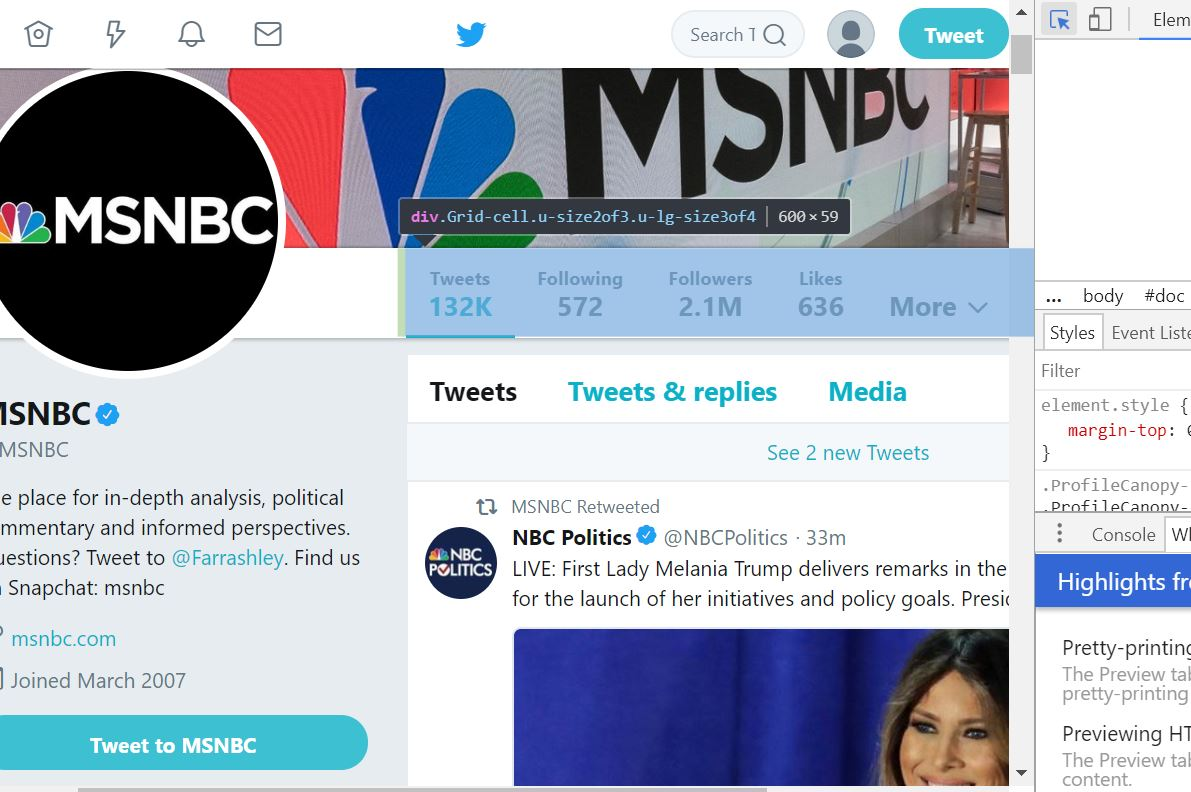

In [ ]:
import os
import sys
import bs4
import urllib

with open('twitter_users.csv', 'w', newline='', encoding='utf-8') as csvFacebook:
    writer_facebook = csv.writer(csvFacebook, delimiter=',')
    writer_facebook.writerow(['row_id', 'screen_name', 'Tweets count', 'Following', 'Followers', 'Likes'])
    file_path = 'https://twitter.com/'
    counter = 0
    for name in all_unique_users:
        counter = counter + 1
        url = file_path + name
        r = requests.get(url)
        data = r.text
        soup = bs4.BeautifulSoup(data, 'html.parser')
        elements = soup.find_all('span', {'class': 'ProfileNav-value'})
        ele_txt = []
        for e in elements:
            extract_data_value = e.get('data-count')
            if extract_data_value is None:
                ele_txt.append(extract_data_value)
            else:
                ele_txt.append(int(float(extract_data_value)))
#         print(counter, name, ele_txt)
        if len(ele_txt) >= 4:
            writer_facebook.writerow([counter, name, ele_txt[0], ele_txt[1], ele_txt[2], ele_txt[3]])
        elif len(ele_txt) == 3:
            writer_facebook.writerow([counter, name, ele_txt[0], ele_txt[1], ele_txt[2], ""])
        elif len(ele_txt) == 2:
            writer_facebook.writerow([counter, name, ele_txt[0], ele_txt[1], "", ""])
        elif len(ele_txt) == 1:
            writer_facebook.writerow([counter, name, ele_txt[0],  "", "", ""])
        else:
            writer_facebook.writerow([counter, name, "",  "", "", ""])

## Visualise the user information

We will try to use the user information to try and gain further insights.


In [44]:
twitter_users = pd.read_csv('twitter_users_information.csv', dtype={'screen_name':object})
# tweets_count = twitter_users.loc[:, 'Tweets count'].astype(np.object)
twitter_users.head(5)

,row_id,screen_name,Tweets count,Following,Followers,Likes
0,1,MSNBC,131463.0,572.0,2099529.0,636.0
1,2,kylegriffin1,38296.0,1036.0,417505.0,40446.0
2,3,RT_com,253767.0,629.0,2699203.0,857.0
3,4,sirrubishagrid,17185.0,138.0,373.0,20342.0
4,5,KeithLockstone,3051.0,41.0,42.0,1.0


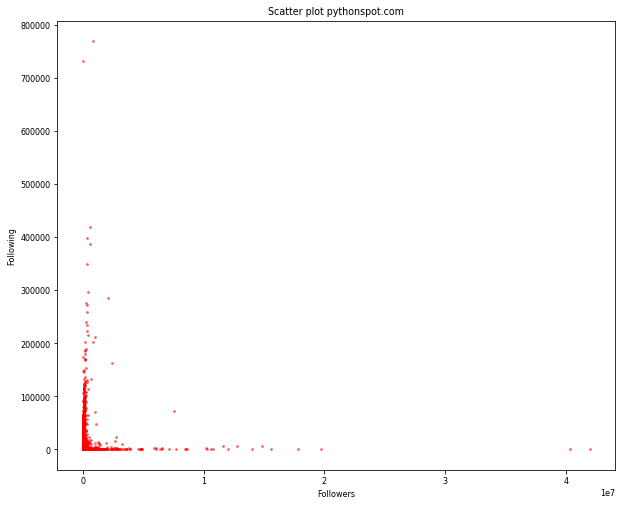

In [45]:
colors = (1, 0, 0)
area = np.pi*1
plt.scatter(twitter_users.Followers, twitter_users.Following, s=area, c=colors, alpha=0.5)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('Followers')
plt.ylabel('Following')
plt.show()

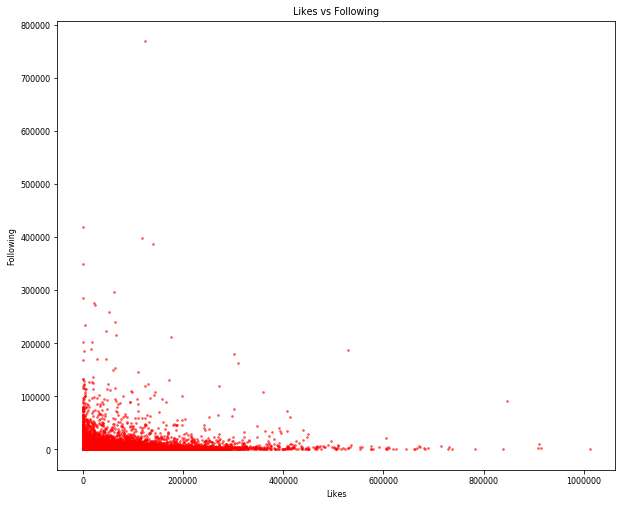

In [46]:
colors = (1, 0, 0)
area = np.pi*1
plt.scatter(twitter_users.Likes, twitter_users.Following, s=area, c=colors, alpha=0.5)
plt.title('Likes vs Following')
plt.xlabel('Likes')
plt.ylabel('Following')
plt.show()

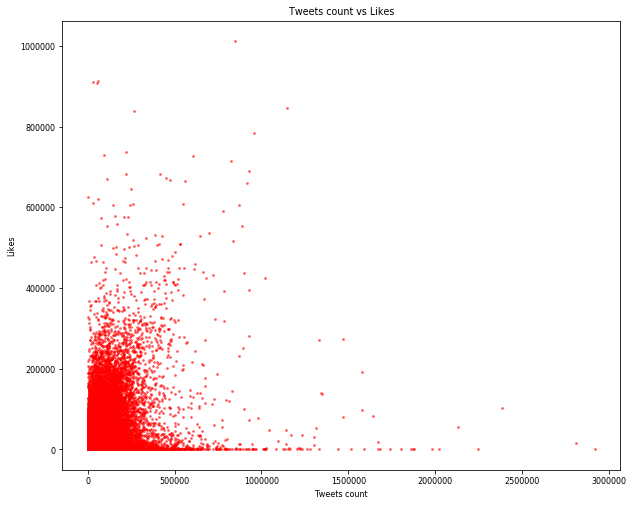

In [47]:
colors = (1, 0, 0)
area = np.pi*1
plt.scatter(twitter_users['Tweets count'], twitter_users.Likes, s=area, c=colors, alpha=0.5)
plt.title('Tweets count vs Likes')
plt.xlabel('Tweets count')
plt.ylabel('Likes')
plt.show()

#### 200,000 users tweeted, and mining relationship between extracted users attributes does not bring much value.



#### Our device could not produce a few visulization like histograms, as our laptops would freeze due to the size of the data being compressed into bins. Hence we have gone ahead with Sentiment Analysis along with Geo-spatial mapping.



## Using TextBlob for Sentiment Analysis

Sentiment Analysis requires a dataset to "train" and test. Unfortunately we do not have a labeled dataset that we could use to learn, looking at a tweets text if the tweets is of positive or negative sentiment.

We can perform the same using Python's [textblob library](http://textblob.readthedocs.io/en/dev/). TextBlob contains a labeled dataset with movie reviews, where the labels are numeric values of "-1" to "+1". 

We will try out it's in-built classifiers to classify the tweets from the users. Ultimately we should be able to associate the users having positive or negative views on the topics that we have searched for.

In [25]:
from textblob import TextBlob
classify_tweets = pd.read_csv('facebook_related_tweets.csv', dtype={'location':object})
classify_tweets.head(5)

,row_id,screen_name,tweet_text,location,lat_coord,lon_coord,lat_box_coord,lon_box_coord
0,1,MSNBC,exclusive yet another cambridge analytica whis...,NaN,NaN,NaN,NaN,NaN
1,2,kylegriffin1,cambridge analytica agreed to give a political...,"Manhattan, NY",NaN,NaN,NaN,NaN
2,3,RT_com,google has capabilities beyond george orwell’s...,NaN,NaN,NaN,NaN,NaN
3,4,sirrubishagrid,mark zuckerberg will testify before congress i...,NaN,NaN,NaN,NaN,NaN
4,5,KeithLockstone,how cambridge analytica’s facebook targeting m...,"Pevensey Bay, England",NaN,NaN,NaN,NaN


In [26]:
clean_classify_tweets = pd.np.array(classify_tweets.tweet_text)
tweet_text_list = [i for i in clean_classify_tweets] 

sentiment = []
polarity = []
# print(len(tweet_text_list), type(tweet_text_list))
for tweet in tweet_text_list:
    # use TextBlob object to analyse tweet text
    analyse_my_sentiment = TextBlob(tweet)
    polarity.append(analyse_my_sentiment.sentiment.polarity)
    # create a sentiment
    if analyse_my_sentiment.sentiment.polarity > 0:
        sentiment.append('positive') 
    elif analyse_my_sentiment.sentiment.polarity == 0:
        sentiment.append('neutral')
    else:
        sentiment.append('negative')

# print(sentiment)
classify_tweets['sentiment'] = sentiment
classify_tweets['polarity'] = polarity

In [27]:
classify_tweets.head(5)

,row_id,screen_name,tweet_text,location,lat_coord,lon_coord,lat_box_coord,lon_box_coord,sentiment,polarity
0,1,MSNBC,exclusive yet another cambridge analytica whis...,NaN,NaN,NaN,NaN,NaN,positive,0.90000
1,2,kylegriffin1,cambridge analytica agreed to give a political...,"Manhattan, NY",NaN,NaN,NaN,NaN,positive,0.05000
2,3,RT_com,google has capabilities beyond george orwell’s...,NaN,NaN,NaN,NaN,NaN,neutral,0.00000
3,4,sirrubishagrid,mark zuckerberg will testify before congress i...,NaN,NaN,NaN,NaN,NaN,positive,0.21746
4,5,KeithLockstone,how cambridge analytica’s facebook targeting m...,"Pevensey Bay, England",NaN,NaN,NaN,NaN,positive,0.20000


In [28]:
ctr = collections.Counter(sentiment)
sizes = []
sizes_percent = []
for i in ctr.keys():
    sizes.append(ctr[i])
    percent_calc = round((float(ctr[i]) / float(sum(ctr.values())) * 100), 2)
    sizes_percent.append(percent_calc)
    print("The percentage of {} tweets : {}% (total number of tweets {})".format(i, round(percent_calc,2), ctr[i]))

The percentage of positive tweets : 39.07% (total number of tweets 141716)
The percentage of neutral tweets : 38.01% (total number of tweets 137868)
The percentage of negative tweets : 22.93% (total number of tweets 83169)


### Tweets sentiments distribution

It shows us that there was no big negative impact from this unless **23%** is a big portion of the users tweeting against this event.

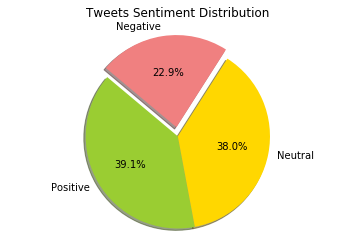

In [29]:
labels = 'Positive', 'Neutral', 'Negative'
colors = ['yellowgreen', 'gold', 'lightcoral']
explode = (0, 0, 0.1)  # explode 1st slice
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Tweets Sentiment Distribution')
plt.show()

In [31]:
classify_tweets_copy = classify_tweets.iloc[:, :].copy()
pred_data = classify_tweets_copy.drop(['tweet_text', 'location', 'lat_coord', 'lon_coord', 
                                       'lat_box_coord', 'lon_box_coord', 'sentiment'], axis=1)
# tweet_text	location	lat_coord	lon_coord	lat_box_coord	lon_box_coord	sentiment
pred_data = pred_data.groupby('screen_name').sum()

user_sentiment = []
for i in pred_data.polarity:
    if i > 0:
        user_sentiment.append('Positive')
    elif i == 0:
        user_sentiment.append('Neutral')
    elif i < 0:
        user_sentiment.append('Negative')

# print(len(user_sentiment))
ctr = collections.Counter(user_sentiment)
sizes = []
sizes_percent = []
for i in ctr.keys():
    sizes.append(ctr[i])
    percent_calc = round((float(ctr[i]) / float(sum(ctr.values())) * 100), 2)
    sizes_percent.append(percent_calc)
    print("The percentage of {} tweets : {}% (total number of tweets {})".format(i, round(percent_calc,2), ctr[i]))

The percentage of Positive tweets : 46.55% (total number of tweets 93184)
The percentage of Neutral tweets : 27.82% (total number of tweets 55679)
The percentage of Negative tweets : 25.63% (total number of tweets 51304)


### Users sentiments distribution

It shows us that there was no big negative impact from this unless **25%** is a big portion of the overall users against this event.

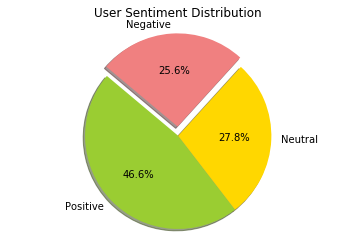

In [32]:
labels = 'Positive', 'Neutral', 'Negative'
colors = ['yellowgreen', 'gold', 'lightcoral']
explode = (0, 0, 0.1)  # explode 1st slice
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('User Sentiment Distribution')
plt.show()

**Some insights can be interesting such as there is still positive number **(neutral is basically positive and have a chance to change their minds)** of opinions even after such an event for 'Facebook'.**

## Geo-Spatial Analysis of the tweets

Even after collecting information from different sources within the JSON string accessing the Twitter API we were able to track location of only 3.3 % of the tweets downloaded. This problem has been documented several places where researchers studying people behaviour have to take measured steps to sample the data available.

We are going to read from our data in the final tweets file and only plot those instances of tweets for which we have the coordinates.

* Standard Library for Geo-Spatial analysis
    * [mpl_toolkits.basemap](https://matplotlib.org/basemap/users/installing.html)
    
First we need to clean and get rid of the 'NAN' values and use the 1195 observations (tweets) which have a location, the dataframe will look something like below and we will leverage the **pandas read_csv** for the same.


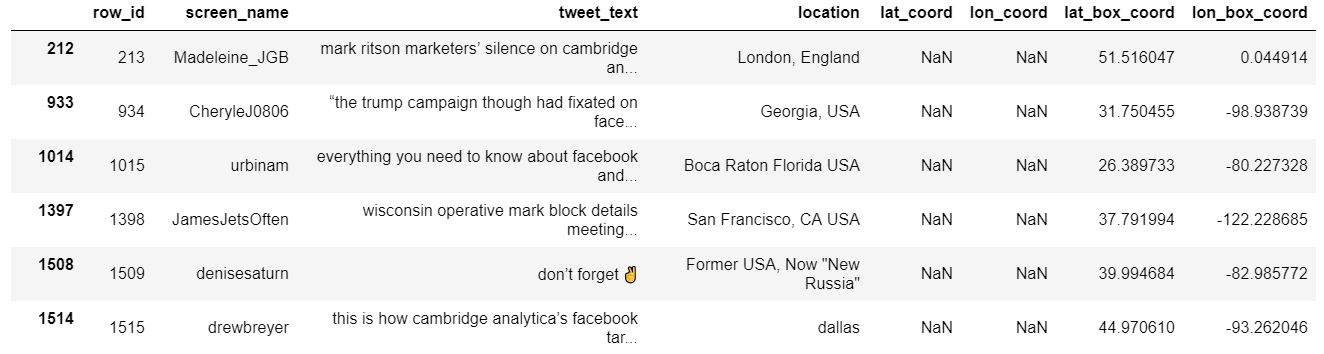

In [ ]:
building_map = pd.read_csv('facebook_related_tweets.csv')
# print(building_map.head(5))
print(building_map.shape)

In [ ]:
cleaned_building_map = building_map.dropna(subset = ['lat_box_coord', 'lon_box_coord'])
print(cleaned_building_map.shape)
# print(cleaned_building_map.head(5))

Now we need to convert the pandas dataframe into a list for the Latitude and Longitude. This is a requirement as the basemap uses list as data structures for its values. The following steps in the process are fairly simple:
    
   * Define the minimum and maximum lattude and longitude for the boundaries (with a margin if required)
   * create a Basemap: 
       * Center of the map
       * Resolution = full or high (others options like crude, low, intermediate)
       * Projection as 'Mercator' [other projections](https://matplotlib.org/basemap/users/mapsetup.html)
   * Draw Coastlines, Countries, States, Map boundaries and fill with colors in the map
   * Converting (lat & lon) to map projection coordinates
   * Plot the figure of a certain size by passing the parameters along with lat, long


Source: 
* [Reference 1](https://stackoverflow.com/questions/44488167/plotting-lat-long-points-using-basemap)
* [Reference 2](http://www.datadependence.com/2016/06/creating-map-visualisations-in-python/)

In [ ]:
from mpl_toolkits.basemap import Basemap

# lat = cleaned_building_map.lat_box_coord
location_data = cleaned_building_map.iloc[:, -2:].copy()
clean_location_data = pd.np.array(location_data)
lat = [i[0] for i in clean_location_data] 
lon =  [i[1] for i in clean_location_data] 
# print(len(lat), type(lat), type(lon))

In [ ]:
# determine range to print based on min, max lat and lon of the data
margin = 10 # buffer to add to the range
lat_min = min(lat) - margin
lat_max = max(lat) + margin
lon_min = min(lon) - margin
lon_max = max(lon) + margin

fig, ax = plt.subplots(figsize=(20,35))

# create map using BASEMAP
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(lon_max-lon_min)/2,
            projection='merc',
            resolution = 'f',
            area_thresh=10000.,
            )
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color = 'white',lake_color='#46bcec')
# convert lat and lon to map projection coordinates
lons, lats = m(lon, lat)
# plot points as red dots
m.scatter(lons, lats, marker = 'o', color='r', zorder=5)
plt.show()
fig.savefig('my_graph_image.png')

### Will capture the below image:

We can clearly see high activity in countries affect by this event of cmabridge analytics namely **United States**, **UK**, **India**, **Singapore** and other locations as well.

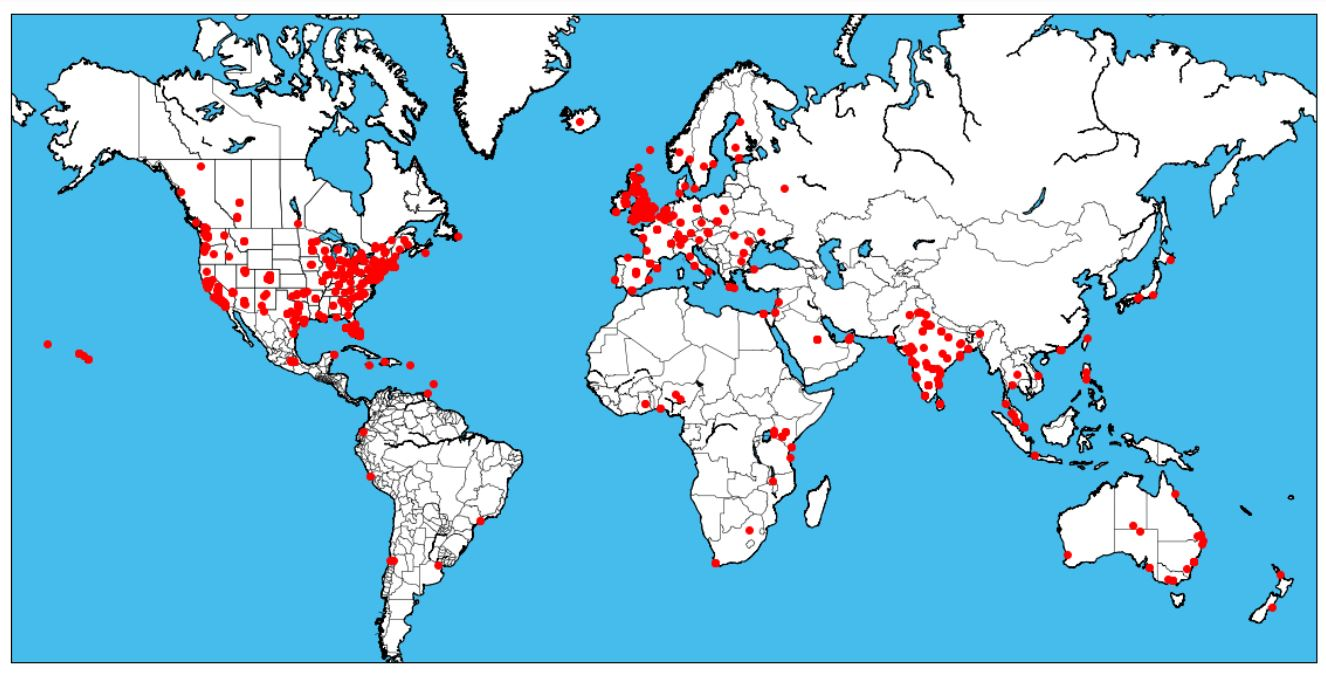

## Additional Enhancements

* Improve sentiment classifier
* Extract more locations from other sources
* Add additional users from other social media networks
* Evaluate user details with sentiments may bring more value
* Heat-map for the sentiment with geo-spatial analysis (merge sentiment analysis with the geo-spatial analysis)

## Lessons Learned

* Locations extractions are always difficult and this problem has been well document in several research journals use Google Geo-code API.
* Best practices to scrape and access API’s while managing constraints such as authentication, pagination, rate limiting etc.
    * Application based authentication (versus User)


## Future Work

Major functions that are needed to be included:
* Create our own text classifier (the below are a few line of code that would be required to gp ahead with the idea)
    * Tokenize all words (using [nltk library](https://www.nltk.org/))
    * Use process functions for all tweets
    * Create training and testing
    * Try differnet models, an choose one as your classifier

In [60]:
import nltk
def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    # convert lowercase
    norm = text.lower()
    # strip \n from line
    norm = norm.strip()
    # replace - with spaces
    new_str = norm.replace("-", " ")
    # replace 's with null
    new_str = new_str.replace("'s", "")
    # replace ' with blank
    new_str = new_str.replace("'", "")
    for c in string.punctuation:
        new_str = new_str.replace(c, " ")
    # get words using mltk
    tokens = nltk.word_tokenize(new_str)
#     print(tokens)
    final_list = []
    for i in tokens:
        try:
            if len(i) > 0:
                final_list.append(lemmatizer.lemmatize(i))
        except:
            continue
    # strip \n from line
    norm = text.strip()
    return final_list

# Testing
text = "I'm doing well! How about you?"
# text = "5,500"
# text = "https://t.co/nxIgrc3hdi \n"
# text = "https://t.co/OoH9FVb7QS"
# text = "mike_pence, 'rt"
print(process(text))

['im', 'doing', 'well', 'how', 'about', 'you']


In [61]:
classify_tweets = pd.read_csv('facebook_related_tweets.csv', dtype={'location':object})
tweet_text = classify_tweets.loc[:, 'tweet_text'].astype(np.object)
processed_tweets_text = [process(i) for i in tweet_text] 
processed_tweets_text[:2]

[['exclusive',
  'yet',
  'another',
  'cambridge',
  'analytica',
  'whistleblower',
  'ha',
  'come',
  'forward',
  'and',
  'she',
  'claim',
  'facebook',
  'data',
  'policy',
  'is',
  'incredibly',
  'irresponsible',
  'watch',
  'tonight',
  'at',
  '6',
  'pm',
  'et'],
 ['cambridge',
  'analytica',
  'agreed',
  'to',
  'give',
  'a',
  'political',
  'action',
  'committee',
  'founded',
  'by',
  'john',
  'bolton',
  'data',
  'harvested',
  'from',
  'million',
  'of',
  'facebook',
  'user',
  'document',
  'released',
  'by',
  'parliament',
  'show']]